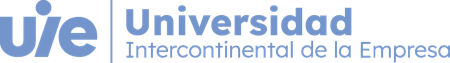

**G25GXX3.10X. Aprendizaje Automático**

**Profesor: Borja González Seoane**

Curso 2025-26

# PROY.XX. Inferencia proyecto

_Notebook_ plantilla para cargar un modelo entrenado y usarlo para hacer inferencia sobre nuevos datos.


In [1]:
from typing import Literal

In [2]:
CSV_FILE_INPUT = "proy_supermercado_dev.csv"  # Este archivo se reemplazaría por el archivo de la partición reservada de test para la fase competitiva

TAREA: Literal["clasificacion", "regresion"] = "clasificacion"  # Cambiar a "regresion" si es una tarea de regresión

MODEL_FILE_INPUT = f"modelo_{TAREA}.pkl"
TEST_SPLIT = .3

In [3]:
import pandas as pd
import joblib  # autoflake: ignore
import pickle  # autoflake: ignore

## Cargar datos y transformar conforme se requiera

En esta celda se deberían replicar las transformaciones que se aplicaron a los datos de entrenamiento para que el modelo pueda hacer predicciones correctas.


In [ ]:
df = pd.read_csv(CSV_FILE_INPUT)

  # autoflake: ignore

In [5]:
import pandas as pd
import numpy as np
from typing import Literal

def preprocess_data_base(df: pd.DataFrame) -> pd.DataFrame:
    """
    PREPROCESAMIENTO BASE - se aplica SIEMPRE, tanto para clasificación como para regresión.
   
    """
   

    # Copia de trabajo para no tocar el df original
    datos = df.copy()
    columnas_eliminar = [
    "id", "nombre", "apellidos", "direccion", "telefono1", "telefono2",
    "email", "dni", "tarjeta_credito_asociada", "usuario_alta_datos", "fecha_cliente", 
    ]
    datos.drop(columns=columnas_eliminar, inplace=True, errors="ignore")
    datos = datos.drop_duplicates(keep='first')
    if "anio_nacimiento" in datos.columns:
        datos["edad"] = 2025 - datos["anio_nacimiento"]
        datos.drop(columns=["anio_nacimiento"], inplace=True)

    
    # Realizamos imputación inteligente por grupos 
    # Imputamos ingresos por estado civil
    if 'ingresos' in datos.columns and 'estado_civil' in datos.columns:
        datos['ingresos'] = datos.groupby('estado_civil')['ingresos'].transform(
            lambda x: x.fillna(x.median())
        )
        # Backup: Si el grupo no tiene datos, usamos la mediana global
        datos['ingresos'] = datos['ingresos'].fillna(datos['ingresos'].median())

    # Imputamos edad por nivel educativo
    if 'edad' in datos.columns and 'educacion' in datos.columns:
        datos['edad'] = datos.groupby('educacion')['edad'].transform(
            lambda x: x.fillna(x.median())
        )
        datos['edad'] = datos['edad'].fillna(datos['edad'].median())

    # Identificamos tipos de variables para imputación residual
    variables_numericas = datos.select_dtypes(include=["float64", "int64"]).columns.tolist()
    variables_categoricas = datos.select_dtypes(include=["object"]).columns.tolist()

    variables_binarias = [
        col for col in variables_numericas
        if datos[col].dropna().nunique() == 2 and set(datos[col].dropna().unique()).issubset({0, 1})
    ]

    # Realizamos imputación final para cualquier nulo restante
    # Numéricas: mediana
    for col in variables_numericas:
        if datos[col].isnull().sum() > 0:
            datos[col].fillna(datos[col].median(), inplace=True)

    # Binarias: moda
    for col in variables_binarias:
        if datos[col].isnull().sum() > 0:
            datos[col].fillna(datos[col].mode()[0], inplace=True)

    # Categóricas: "Desconocido"
    for col in variables_categoricas:
        if datos[col].isnull().sum() > 0:
            datos[col].fillna("Desconocido", inplace=True)
    
        # Eliminamos outliers extremos manualmente
    datos = datos[datos['edad'] <= 100]
    datos = datos[datos['ingresos'] < 500000]
    datos = datos.reset_index(drop=True)  

    # Identificar outliers con IQR
    columnas_outliers = ['ingresos', 'edad']
    mask_total = pd.Series([True] * len(datos))

    for col in columnas_outliers:
        if col in datos.columns:
            Q1 = datos[col].quantile(0.25)
            Q3 = datos[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            # Acumulamos condiciones
            mask_total &= (datos[col] >= lower_bound) & (datos[col] <= upper_bound)

    # Aplicamos filtro
    datos = datos[mask_total].reset_index(drop=True)  # ← Reset otra vez
    columnas_gasto = [
        "gasto_vinos",
        "gasto_frutas",
        "gasto_carnes",
        "gasto_pescado",
        "gasto_dulces",
        "gasto_oro"
    ]

    datos["gasto_total"] = datos[columnas_gasto].sum(axis=1)

    # Proporción de gasto por categoría
    datos['porcentaje_gasto_vinos'] = datos['gasto_vinos'] / (datos['gasto_total'] + 1)
    datos['porcentaje_gasto_frutas'] = datos['gasto_frutas'] / (datos['gasto_total'] + 1)
    datos['porcentaje_gasto_carnes'] = datos['gasto_carnes'] / (datos['gasto_total'] + 1)
    datos['porcentaje_gasto_pescado'] = datos['gasto_pescado'] / (datos['gasto_total'] + 1)
    datos['porcentaje_gasto_dulces'] = datos['gasto_dulces'] / (datos['gasto_total'] + 1)
    datos['porcentaje_gasto_oro'] = datos['gasto_oro'] / (datos['gasto_total'] + 1)

    datos["total_compras"] = (
    datos["num_compras_web"] +
    datos["num_compras_catalogo"] +
    datos["num_compras_tienda"]
    )

    datos["ticket_medio"] = datos["gasto_total"] / (datos["total_compras"] + 1)
   
# Suma de gastos históricos por categoría
    gasto_historico_total = (
        datos['gasto_vinos'] + datos['gasto_frutas'] + datos['gasto_carnes'] +
        datos['gasto_pescado'] + datos['gasto_dulces'] + datos['gasto_oro']
    )

    # Solo calculamos si hay gasto histórico registrado
    mask_gasto = gasto_historico_total > 0

    # Porcentajes históricos de preferencia
    datos['pct_hist_vinos'] = 0.0
    datos['pct_hist_frutas'] = 0.0
    datos['pct_hist_carnes'] = 0.0
    datos['pct_hist_pescado'] = 0.0
    datos['pct_hist_dulces'] = 0.0
    datos['pct_hist_oro'] = 0.0

    datos.loc[mask_gasto, 'pct_hist_vinos'] = datos.loc[mask_gasto, 'gasto_vinos'] / gasto_historico_total[mask_gasto]
    datos.loc[mask_gasto, 'pct_hist_frutas'] = datos.loc[mask_gasto, 'gasto_frutas'] / gasto_historico_total[mask_gasto]
    datos.loc[mask_gasto, 'pct_hist_carnes'] = datos.loc[mask_gasto, 'gasto_carnes'] / gasto_historico_total[mask_gasto]
    datos.loc[mask_gasto, 'pct_hist_pescado'] = datos.loc[mask_gasto, 'gasto_pescado'] / gasto_historico_total[mask_gasto]
    datos.loc[mask_gasto, 'pct_hist_dulces'] = datos.loc[mask_gasto, 'gasto_dulces'] / gasto_historico_total[mask_gasto]
    datos.loc[mask_gasto, 'pct_hist_oro'] = datos.loc[mask_gasto, 'gasto_oro'] / gasto_historico_total[mask_gasto]

    datos["ingresos_x_edad"] = datos["ingresos"] * datos["edad"]
    datos["totalcompras_x_ingresos"] = datos["total_compras"] * datos["ingresos"]
    datos["compras_per_capita"] = datos["total_compras"] / (datos["hijos_casa"] + datos["adolescentes_casa"] + 1)
    datos['ratio_recencia_edad'] = datos['recencia'] / datos['edad']
    datos['ratio_online_offline'] = (datos['num_compras_web'] + datos['num_compras_catalogo']) / (datos['num_compras_tienda'] + 1)
    datos['intensidad_compra'] = datos['total_compras'] / (datos['recencia'] + 1)
    columnas_constantes = ["coste_contacto", "ingresos_contacto"]
    for col in columnas_constantes:
        if col in datos.columns and datos[col].nunique() == 1:
            datos.drop(columns=[col], inplace=True)

    columnas_campanas = ["acepta_cmp1", "acepta_cmp2", "acepta_cmp3", "acepta_cmp4", "acepta_cmp5"]

    for col in columnas_campanas:
        if col in datos.columns:
            datos[col] = datos[col].astype(str).str.lower().replace({
                "no": 0, "si": 1, "nan": 0, "none": 0, "yes": 1
            })
            datos[col] = pd.to_numeric(datos[col], errors="coerce").fillna(0).astype(int)

    datos['campanas_totales'] = (datos['acepta_cmp1'] + datos['acepta_cmp2'] + 
                              datos['acepta_cmp3'] + datos['acepta_cmp4'] + datos['acepta_cmp5'])
    educacion_mapping = {
    "Basic": 1,
    "2n Cycle": 2,
    "Graduation": 3,
    "Master": 4,
    "PhD": 5,
    "desconocido": 0
}

    # Aplicar mapeo siguiendo tu misma estructura
    datos["educacion"] = datos["educacion"].map(educacion_mapping)

    datos["educacion"] = datos["educacion"].fillna(0)

    columnas_a_codificar = ["estado_civil"]
    columnas_a_codificar = [c for c in columnas_a_codificar if c in datos.columns]

    datos = pd.get_dummies(datos, columns=columnas_a_codificar, drop_first=True)
    columnas_booleanas = datos.select_dtypes(include=['bool']).columns
    datos[columnas_booleanas] = datos[columnas_booleanas].astype(int)



    return datos


def preprocess_data_regresion(df_base: pd.DataFrame) -> pd.DataFrame:
    """
    PREPROCESAMIENTO ESPECÍFICO PARA REGRESIÓN.
    Parte SIEMPRE de los datos ya pasados por preprocess_data_base.
    Replica lo que haces en preprocesamiento_regresion.ipynb,
    pero sin lecturas/escrituras de CSV ni prints/plots.
    """

    datos = df_base.copy()


    datos['ingresos_sq'] = datos['ingresos'] ** 2  # Cuadrática
    datos['total_compras_sq'] = datos['total_compras'] ** 2

    # Ratios adicionales
    datos['ingresos_per_capita'] = datos['ingresos'] / (datos['hijos_casa'] + datos['adolescentes_casa'] + 1)
    datos['gasto_por_ingreso_estimado'] = datos['totalcompras_x_ingresos'] / (datos['ingresos'] + 1)

    # Interacción entre compras online/offline
    datos['compras_web_x_catalogo'] = datos['num_compras_web'] * datos['num_compras_catalogo']

    # Raíz cuadrada (captura crecimientos decrecientes)
    datos['ingresos_sqrt'] = np.sqrt(datos['ingresos'])
    datos['total_compras_sqrt'] = np.sqrt(datos['total_compras'])

    datos['ingresos_x_num_catalogo'] = datos['ingresos'] * datos['num_compras_catalogo']
    datos['total_compras_x_catalogo'] = datos['total_compras'] * datos['num_compras_catalogo']


  

    # Eliminamos componentes y derivadas de gasto_total
    columnas_eliminar = [
        # SOLO componentes directos y derivadas matemáticas de gasto_total
        'gasto_vinos', 'gasto_frutas', 'gasto_carnes',
        'gasto_pescado', 'gasto_dulces', 'gasto_oro',
        'porcentaje_gasto_vinos',
        'porcentaje_gasto_frutas',
        'porcentaje_gasto_carnes',
        'porcentaje_gasto_pescado',
        'porcentaje_gasto_dulces',
        'porcentaje_gasto_oro',
        'ticket_medio',
        'respuesta'  # Variable de clasificación
    ]

    # Eliminamos solo las columnas que existan
    columnas_a_eliminar = [col for col in columnas_eliminar if col in datos.columns]
    datos_regresion = datos.drop(columns=columnas_a_eliminar)


   

    # Nos quedamos con las 15 variables más correlacionadas
    top_15_vars = [  # Variables originales fuertes (sin redundancia)
        'totalcompras_x_ingresos',     # +0.8711 (interacción ya existente)
        'total_compras',               # +0.8206
        'ingresos',                    # +0.8172

        # SOLO 1 transformación cuadrática (la mejor)
        'ingresos_sq',                 # +0.8410 (añadir no-linealidad)

        # Variables de comportamiento
        'num_compras_catalogo',        # +0.7936
        'num_compras_tienda',          # +0.6812
        'num_compras_web',             # +0.5251

        # Variables demográficas (importantes aunque negativas)
        'hijos_casa',                  # -0.5649
        'ingresos_x_edad',             # +0.7039

        # Interacción de canales (NO basada en ingresos)
        'compras_web_x_catalogo',      # +0.7318

        # Variables de engagement
        'num_visitas_web_mes',         # -0.4942
        'campanas_totales',            # +0.3890
        'acepta_cmp5',                 # +0.4025

        # Ratios adicionales (solo 1)
        'compras_per_capita',          # +0.8294

        # Variable histórica
        'pct_hist_oro'                 # -0.4366
    ]

    # Guardamos el nuevo dataset con las variables seleccionadas
    variables_a_guardar = [v for v in top_15_vars if v in datos_regresion.columns] + ['gasto_total']
    datos_regresion_final = datos_regresion[variables_a_guardar]

    return datos_regresion_final


In [6]:
df_base = preprocess_data_base(df)

In [14]:
display(df_base.head() )

,educacion,ingresos,hijos_casa,adolescentes_casa,recencia,gasto_vinos,gasto_frutas,gasto_carnes,gasto_pescado,gasto_dulces,...,intensidad_compra,campanas_totales,estado_civil_Alone,estado_civil_Desconocido,estado_civil_Divorced,estado_civil_Married,estado_civil_Single,estado_civil_Together,estado_civil_Widow,estado_civil_YOLO
0,3.0,53359.0,1.0,1.0,4.0,173.0,4.0,30.0,3.0,6.0,...,2.000000,0,0,0,0,1,0,0,0,0
1,3.0,21474.0,1.0,0.0,0.0,6.0,16.0,24.0,11.0,0.0,...,6.000000,1,0,0,0,0,1,0,0,0
2,3.0,41411.0,0.0,0.0,11.0,37.0,32.0,38.0,11.0,3.0,...,0.583333,0,0,0,1,0,0,0,0,0
3,5.0,64504.0,1.0,2.0,81.0,986.0,36.0,168.0,16.0,0.0,...,0.219512,0,0,0,0,0,0,1,0,0
4,3.0,65169.0,0.0,0.0,23.0,1074.0,0.0,69.0,0.0,0.0,...,1.125000,4,0,0,0,1,0,0,0,0


In [7]:
if TAREA == "clasificacion":
    df_trans = preprocess_data_base(df_base)
    target_col = "respuesta"
else:
    df_trans = preprocess_data_regresion(df_base)
    target_col = "gasto_total"


In [8]:
X_inf = df_trans[[col for col in df_trans.columns if col != target_col]]
y_inf = df_trans[[target_col]]

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_inf, y_inf, test_size=TEST_SPLIT, random_state=42)


## Recuperar modelo entrenado

In [10]:
import pickle

with open(MODEL_FILE_INPUT, "rb") as f:
    model = pickle.load(f)



## Llamada inferencia

In [11]:
y_pred = model.predict(X_test)

## Métricas inferencia

Adáptese conforme a las que se consideren relevantes.

In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [13]:
if TAREA == "clasificacion":
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="weighted")
    recall = recall_score(y_test, y_pred, average="weighted")
    f1 = f1_score(y_test, y_pred, average="weighted")

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
elif TAREA == "regresion":
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Absolute Error: {mae}")
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

Accuracy: 0.8855534709193246
Precision: 0.86883639676716
Recall: 0.8855534709193246
F1 Score: 0.8692718330452608
